In [2]:
#Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])  # converting job_posted_date to datetime object
df['job_skills'] = df['job_skills'].apply(lambda data: ast.literal_eval(data) if pd.notna(data) else data)  # converting job_skills to list

# Filter for Data Analyst data
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()

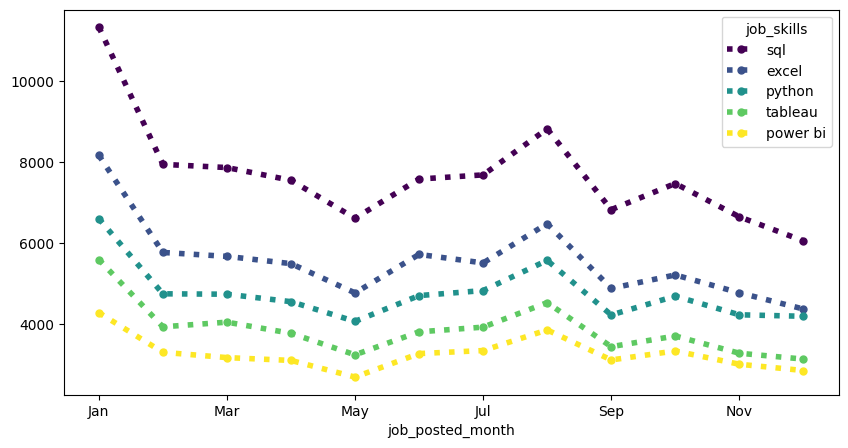

In [18]:
# Create a new column for month number 
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# Explode the job_skills column and pivot
df_DA_explode = df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)

# Sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Get the top 5 skills
df_DA_pivot.iloc[:, :5].plot(
    kind='line',  # matplotlib.pyplot.line -> all different parameters for this kind of plot
    linewidth=4,
    linestyle=':',  # options: '-', '--', '-.', ':'
    colormap='viridis',
    marker='o',  # options: 'o', 'x', '+', '*', 's', ',', '.', '1', '2', '3', '4' ...
    markersize=5,
    figsize=(10, 5),
)

# plt.title('Top 5 Skills for Data Analysts per Month')
# plt.ylabel('Count')
# plt.xlabel('')
plt.show()

In [24]:
# Explode the 'job_skills' into individual rows
df_exploded = df_DA.explode('job_skills')

# Calculate the average salary and count of job postings per skill
skill_stats = df_exploded.groupby('job_skills').agg(
    skill_count=('job_skills', 'count'),
    median_salary=('salary_year_avg', 'median'),
)

# Limit to the top skills
skill_count = 20
skill_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)

skill_stats

,skill_count,median_salary
job_skills,,
sql,92428,92500.000000
excel,66860,84479.000000
python,57190,98500.000000
tableau,46455,95000.000000
power bi,39380,90000.000000
r,29996,92527.500000
sas,27998,90000.000000
powerpoint,13822,85000.000000
word,13562,80000.000000


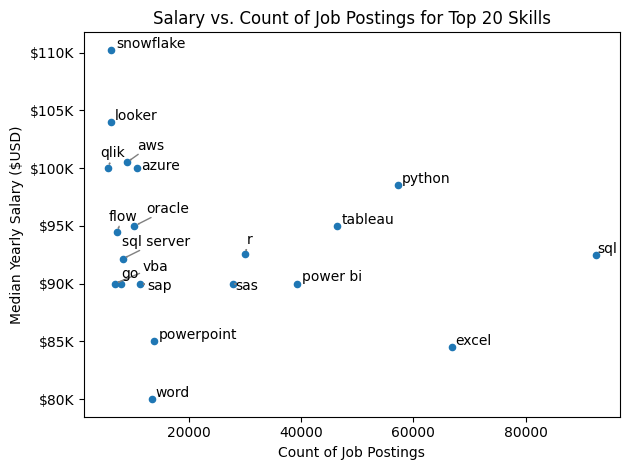

In [30]:
from adjustText import adjust_text

skill_stats.plot(kind='scatter', x='skill_count', y='median_salary')

texts = []
for i, txt in enumerate(skill_stats.index):
    texts.append(plt.text(skill_stats['skill_count'].iloc[i], skill_stats['median_salary'].iloc[i], txt))
    
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=1))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y / 1000)}K'))

plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title(f'Salary vs. Count of Job Postings for Top {skill_count} Skills')
plt.tight_layout()
plt.show()

# Exercises